In [152]:
# dataframe and math
import pandas as pd
import numpy as np
import xgboost as xg

# sklearn
from sklearn.preprocessing import LabelEncoder

# random module
import random

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error,roc_curve
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import KFold, cross_val_score
from scikitplot.metrics import plot_roc

In [155]:
PATHS = {
    'train': 'train.csv',
    'test': 'test.csv',
    'clean_train': "clean_train.csv"
}

DIVISION DE DATASETS

In [156]:
clean_df = pd.read_csv(
    PATHS['clean_train'],
    index_col=0
)

c:\users\majo\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [157]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735561 entries, 0 to 8921482
Data columns (total 51 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   EngineVersion                                      object 
 1   AppVersion                                         object 
 2   AvSigVersion                                       object 
 3   AVProductStatesIdentifier                          float64
 4   AVProductsInstalled                                float64
 5   CountryIdentifier                                  int64  
 6   CityIdentifier                                     float64
 7   GeoNameIdentifier                                  float64
 8   LocaleEnglishNameIdentifier                        int64  
 9   Processor                                          object 
 10  OsBuild                                            int64  
 11  OsSuite                                           

In [158]:
HIGH_CARDINALITY = [
    'EngineVersion',
    'AppVersion', 
    'AvSigVersion',
    'OsBuildLab'
]

In [159]:
clean_df = clean_df.drop(HIGH_CARDINALITY, axis=1)

In [160]:
has_battery = []

for record in clean_df['Census_InternalBatteryNumberOfCharges']:
    entry = record if record == 0 else 1
    has_battery.append(entry)

In [161]:
has_battery_series = pd.Series(has_battery)
clean_df['HasBatteryCharges'] = has_battery_series.values

In [162]:
clean_df = clean_df.drop('Census_InternalBatteryNumberOfCharges', axis=1)

In [163]:
TO_CATEGORY = clean_df.columns[clean_df.dtypes.eq('object')]

TO_CATEGORY_NUMERIC = [
    'Census_IsSecureBootEnabled',
    'Census_IsTouchEnabled',
    'Wdft_IsGamer',
    'Wdft_RegionIdentifier'
]

In [164]:
le = LabelEncoder()

clean_df[TO_CATEGORY] = clean_df[TO_CATEGORY].apply(le.fit_transform)
clean_df[TO_CATEGORY_NUMERIC] = clean_df[TO_CATEGORY_NUMERIC].apply(le.fit_transform)

In [165]:
clean_df.head()

,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Processor,OsBuild,OsSuite,OsPlatformSubRelease,...,Census_GenuineStateName,Census_ActivationChannel,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,HasBatteryCharges
0,53447.0,1.0,29,128035.0,35.0,171,1,17134,256,4,...,1,2,628.0,36144.0,0,0,0,9,0,1.0
1,53447.0,1.0,93,1482.0,119.0,64,1,17134,256,4,...,2,2,628.0,57858.0,0,0,0,7,0,1.0
2,53447.0,1.0,86,153579.0,64.0,49,1,17134,768,4,...,1,1,142.0,52682.0,0,0,0,2,0,1.0
3,53447.0,1.0,88,20710.0,117.0,115,1,17134,256,4,...,1,1,355.0,20050.0,0,0,0,2,1,1.0
4,53447.0,1.0,18,37376.0,277.0,75,1,17134,768,4,...,1,2,355.0,19844.0,0,0,0,0,1,0.0


In [166]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735561 entries, 0 to 8921482
Data columns (total 47 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   AVProductStatesIdentifier                          float64
 1   AVProductsInstalled                                float64
 2   CountryIdentifier                                  int64  
 3   CityIdentifier                                     float64
 4   GeoNameIdentifier                                  float64
 5   LocaleEnglishNameIdentifier                        int64  
 6   Processor                                          int32  
 7   OsBuild                                            int64  
 8   OsSuite                                            int64  
 9   OsPlatformSubRelease                               int32  
 10  SkuEdition                                         int32  
 11  IeVerIdentifier                                   

X & Y

In [167]:
target = clean_df['HasDetections']

In [168]:
features = clean_df.drop('HasDetections', axis=1)

In [169]:
from sklearn.model_selection import train_test_split

In [170]:
sample_ratio = 0.25

In [171]:
_, X_sample, _, y_sample = train_test_split(features, target, test_size = sample_ratio)

In [172]:
print("Se trabajará con una muestra del %.0f%% de los datos originales" % (len(X_sample) / len(clean_df) * 100))

Se trabajará con una muestra del 25% de los datos originales


In [173]:
## Revisamos el balance de los datos
y_sample.value_counts()

1    968966
0    964925
Name: HasDetections, dtype: int64

SCALING

In [174]:
df_columns = X_sample.columns

In [177]:
s_scaler = StandardScaler()

In [178]:
X_scaled = s_scaler.fit_transform(X_sample)
X_scaled = pd.DataFrame(X_scaled, columns=df_columns)

MODELS

In [217]:
def plot_roc_curve(model,X_test,y_test,is_xgb=False):
    n_classes = 2
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        if is_xgb:
            preds = model.predict(X_test)
            fpr[i], tpr[i], _ = roc_curve(y_test, [1.0 - f for f in preds], pos_label=i)
        else:
            fpr[i], tpr[i], _ = roc_curve(y_test, model.predict_proba(X_test)[:,i], pos_label=i)

    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Denial of Service R-U-Dead-Yet vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Denial of Service Slowloris vs Rest')
 
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)

In [180]:
## function for plotting confusion matrix in a more comprehensive format
def plot_confusion_matrix(matrix, title):
    group_names = ['Real Negativo','Falso Positivo','Falso Negativo','Real Positivo']
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten() / np.sum(matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='BuPu')

    ax.set_title('Matriz de Confusión de {}\n'.format(title));

    ax.xaxis.set_ticklabels(['No Detections','Detections'])
    ax.yaxis.set_ticklabels(['No Detections','Detections'])
    ax.set_xlabel('Valores Predichos');
    ax.set_ylabel('Valores Correctos ');
    
    plt.show()

In [181]:
test_ratio = 0.3

In [182]:
## X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sample, test_size = test_ratio)

In [184]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [185]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric':'auc'
}

num_boost_round = 999

In [186]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
max_auc = float(0)
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
    
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

In [ ]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [189]:
params

{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [190]:
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.64316
[1]	Test-auc:0.64923
[2]	Test-auc:0.65222
[3]	Test-auc:0.65435
[4]	Test-auc:0.65620
[5]	Test-auc:0.65757
[6]	Test-auc:0.65904
[7]	Test-auc:0.66041
[8]	Test-auc:0.66268
[9]	Test-auc:0.66395
[10]	Test-auc:0.66512
[11]	Test-auc:0.66612
[12]	Test-auc:0.66679
[13]	Test-auc:0.66711
[14]	Test-auc:0.66803
[15]	Test-auc:0.66835
[16]	Test-auc:0.66917
[17]	Test-auc:0.66949
[18]	Test-auc:0.67018
[19]	Test-auc:0.67050
[20]	Test-auc:0.67092
[21]	Test-auc:0.67122
[22]	Test-auc:0.67144
[23]	Test-auc:0.67153
[24]	Test-auc:0.67217
[25]	Test-auc:0.67252
[26]	Test-auc:0.67270
[27]	Test-auc:0.67295
[28]	Test-auc:0.67314
[29]	Test-auc:0.67338
[30]	Test-auc:0.67347
[31]	Test-auc:0.67362
[32]	Test-auc:0.67388
[33]	Test-auc:0.67401
[34]	Test-auc:0.67410
[35]	Test-auc:0.67409
[36]	Test-auc:0.67412
[37]	Test-auc:0.67437
[38]	Test-auc:0.67438
[39]	Test-auc:0.67450
[40]	Test-auc:0.67462
[41]	Test-auc:0.67484
[42]	Test-auc:0.67478
[43]	Test-auc:0.67483
[44]	Test-auc:0.67478
[45]	Test-auc:0.6748

In [191]:
xgb_preds = xgb_model.predict(dtest)

binary_preds = [0 if x < 0.5 else 1 for x in xgb_preds]

In [192]:
xgb_cm = confusion_matrix(y_test, binary_preds)

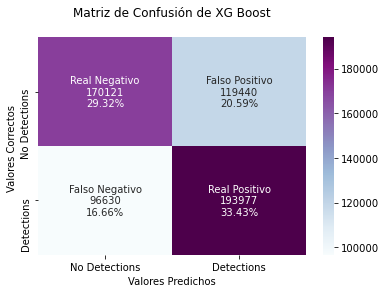

In [193]:
plot_confusion_matrix(xgb_cm, "XG Boost")

In [194]:
print(classification_report(y_test, binary_preds))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61    289561
           1       0.62      0.67      0.64    290607

    accuracy                           0.63    580168
   macro avg       0.63      0.63      0.63    580168
weighted avg       0.63      0.63      0.63    580168



In [ ]:
plot_roc_curve(xgb_model,dtest,y_test,is_xgb=True)

RANDOM FOREST

In [196]:
#Cleaning Columns for model
xt_clean = X_train.drop(columns=['AVProductStatesIdentifier', 'AVProductsInstalled', 'CityIdentifier','GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName','Census_GenuineStateName','Census_ActivationChannel','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsTouchEnabled','Census_IsTouchEnabled','Wdft_RegionIdentifier','OsPlatformSubRelease','SkuEdition','Census_MDC2FormFactor','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_PowerPlatformRoleName','Census_OSVersion','Census_OSBranch','Census_OSEdition','Census_OSSkuName','Census_OSInstallTypeName','Processor'], axis=1)
yt_clean = y_train.drop(columns=['AVProductStatesIdentifier', 'AVProductsInstalled', 'CityIdentifier','GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName','Census_GenuineStateName','Census_ActivationChannel','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsTouchEnabled','Census_IsTouchEnabled','Wdft_RegionIdentifier','OsPlatformSubRelease','SkuEdition','Census_MDC2FormFactor','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_PowerPlatformRoleName','Census_OSVersion','Census_OSBranch','Census_OSEdition','Census_OSSkuName','Census_OSInstallTypeName','Processor'], axis=1)

xtest_clean = X_test.drop(columns=['AVProductStatesIdentifier', 'AVProductsInstalled', 'CityIdentifier','GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName','Census_GenuineStateName','Census_ActivationChannel','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsTouchEnabled','Census_IsTouchEnabled','Wdft_RegionIdentifier','OsPlatformSubRelease','SkuEdition','Census_MDC2FormFactor','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_PowerPlatformRoleName','Census_OSVersion','Census_OSBranch','Census_OSEdition','Census_OSSkuName','Census_OSInstallTypeName','Processor'], axis=1)
ytest_clean = y_test.drop(columns=['AVProductStatesIdentifier', 'AVProductsInstalled', 'CityIdentifier','GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName','Census_GenuineStateName','Census_ActivationChannel','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Census_IsSecureBootEnabled','Census_IsTouchEnabled','Census_IsTouchEnabled','Wdft_RegionIdentifier','OsPlatformSubRelease','SkuEdition','Census_MDC2FormFactor','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_PowerPlatformRoleName','Census_OSVersion','Census_OSBranch','Census_OSEdition','Census_OSSkuName','Census_OSInstallTypeName','Processor'], axis=1)


In [197]:
model2 = RandomForestClassifier(max_depth=2,random_state=0)
model2.fit(xt_clean, yt_clean)

RandomForestClassifier(max_depth=2, random_state=0)

In [198]:
y_pred = model2.predict(xtest_clean)
ran_forest = confusion_matrix(ytest_clean, y_pred)
print(classification_report(ytest_clean, y_pred))

print('\nAccuracy Score:', accuracy_score(ytest_clean,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42    289561
           1       0.53      0.75      0.62    290607

    accuracy                           0.54    580168
   macro avg       0.55      0.54      0.52    580168
weighted avg       0.55      0.54      0.52    580168


Accuracy Score: 0.5428961955847272


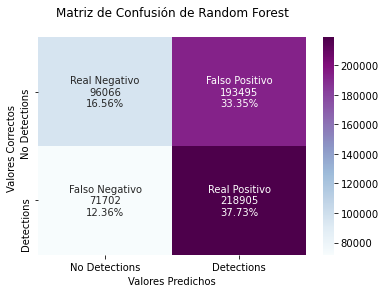

In [199]:
plot_confusion_matrix(ran_forest, "Random Forest")

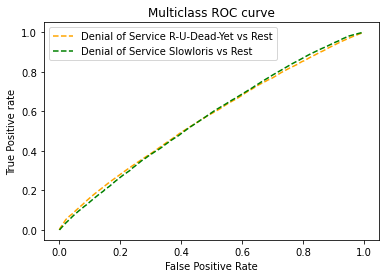

In [219]:
plot_roc_curve(model2, xtest_clean, ytest_clean, False)

END